In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_json('logins.json')  
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df['login_time'] = pd.to_datetime(df['login_time'])
df = df.sort_values('login_time').reset_index(drop=True)
df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [4]:
print(df.info())
print("Data period from", df['login_time'].min(), "to", df['login_time'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None
Data period from 1970-01-01 20:12:16 to 1970-04-13 18:57:38


In [5]:
df.set_index('login_time', inplace=True)

login_counts = df.resample('15T').size()

login_counts.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64

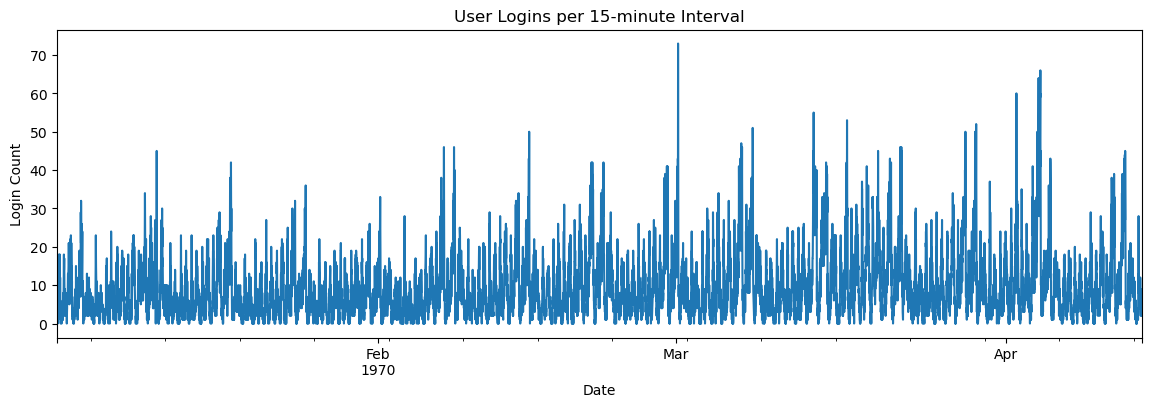

In [6]:
plt.figure(figsize=(14,4))
login_counts.plot()
plt.title('User Logins per 15-minute Interval')
plt.xlabel('Date')
plt.ylabel('Login Count')
plt.show()

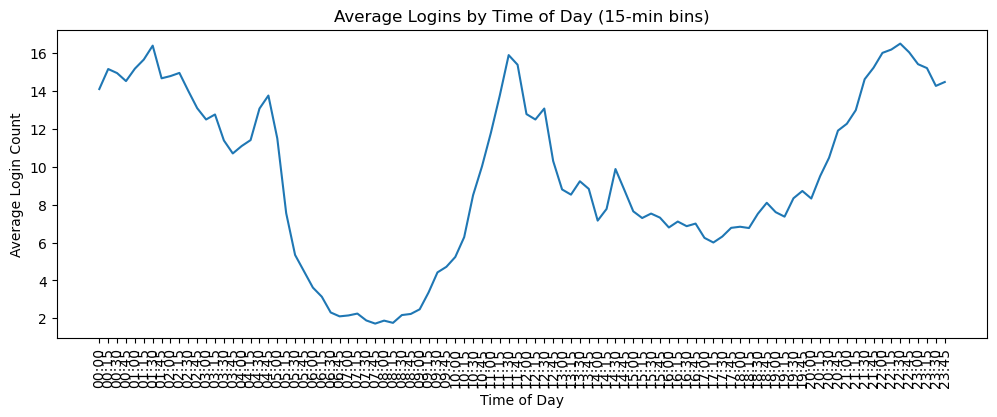

In [7]:
avg_daily_pattern = login_counts.groupby(login_counts.index.time).mean()

time_labels = [t.strftime('%H:%M') for t in avg_daily_pattern.index]

plt.figure(figsize=(12,4))
plt.plot(time_labels, avg_daily_pattern.values)
plt.title('Average Logins by Time of Day (15-min bins)')
plt.xlabel('Time of Day')
plt.ylabel('Average Login Count')
plt.xticks(rotation=90)
plt.show()


In [8]:
login_counts_df = login_counts.to_frame(name='count').reset_index()
login_counts_df['weekday'] = login_counts_df['login_time'].dt.day_name()

login_counts_df['is_weekend'] = login_counts_df['weekday'].isin(['Saturday','Sunday'])

avg_weekday = login_counts_df.groupby([login_counts_df['login_time'].dt.time, 'is_weekend'])['count'].mean().unstack()

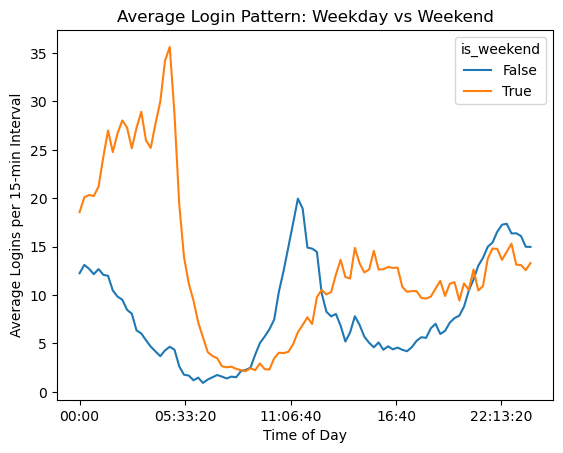

In [9]:
avg_weekday.plot()
plt.title('Average Login Pattern: Weekday vs Weekend')
plt.xlabel('Time of Day')
plt.ylabel('Average Logins per 15-min Interval')
plt.show()

In [10]:
pivot = login_counts_df.pivot_table(
    index=login_counts_df['login_time'].dt.date,
    columns=login_counts_df['login_time'].dt.hour*4 + login_counts_df['login_time'].dt.minute//15,
    values='count',
    aggfunc='sum'
)

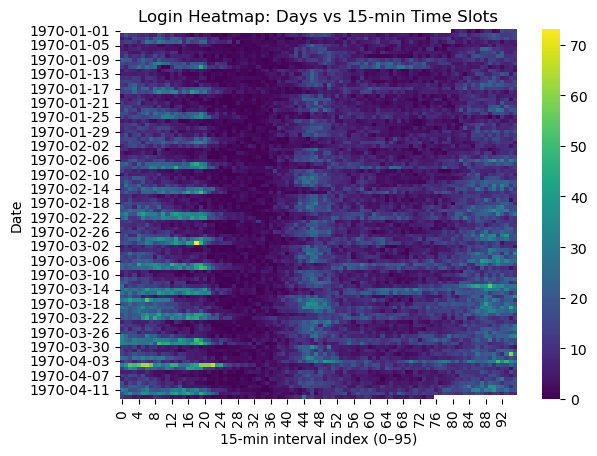

In [11]:
sns.heatmap(pivot, cmap='viridis')
plt.title('Login Heatmap: Days vs 15-min Time Slots')
plt.xlabel('15-min interval index (0–95)')
plt.ylabel('Date')
plt.show()

In [12]:
print("Missing values:", df.isna().sum().sum())
print("Duplicate timestamps:", df.index.duplicated().sum())
print("Average interval between logins:", df.index.to_series().diff().mean())
print("Longest gap between logins:", df.index.to_series().diff().max())


Missing values: 0.0
Duplicate timestamps: 877
Average interval between logins: 0 days 00:01:34.569759826
Longest gap between logins: 0 days 01:31:41


# **Part 2 - Experiment and Metric Design**


### Scenario Summary
Two cities — **Gotham** and **Metropolis** — have complementary activity patterns:

- **Gotham:** Most active at **night (weekdays)**
- **Metropolis:** Most active during the **day (weekdays)**
- **Weekends:** Reasonable activity in both cities

**Problem:**  
Due to a **two-way toll bridge**, driver-partners tend to operate exclusively in one city, limiting flexibility.

**Proposed solution:**  
Reimburse toll costs to encourage drivers to serve both cities.

---

### Step 1: Define the Key Measure of Success

**Goal:** Determine if reimbursing tolls increases cross-city driver activity.

**Primary metric (key measure of success):**
> **Percentage of drivers who complete trips in both cities during the experiment period.**

**Why this metric?**
- Directly measures the desired behavior (drivers serving both cities)
- Simple to calculate and interpret
- Less affected by fluctuations in - and
 
**Formula:**
\
\(ity driver rate} = \frac{\text{Number of drivers /g trips in both cities}}{\text) *mbe0 active drivers}} \times 100
\]

**Secondary metrics (for additional insights):**
- Average trips per driver (to measure productivity)
- Average earnings per driver
- Toll reimbursements per driver (to evaluate cost impact)
- Rider wait time (to measure service improvement)

---

### Step 2: Design the Experiment

#### a) Implementation Plan
1. **Population:** All active drivers in Gotham and Metropolis  
2. **Randomization:**  
   - Randomly assign drivers into two groups:  
     - **Treatment group:** Toll reimbursement enabled  
     - **Control group:** No reimbursement (status quo)  
   - Ensure both groups have similar driver characteristics (activity level, experience, etc.)
3. **Duration:** 4–6 weeks, covering both weekdays and weekends  
4. **Data to Collect:**
   - Driver ID  
   - Trip timestamps and locations (city)  
   - Toll amount reimbursed (if any)  
   - Number of trips per city per driver  

---

### Step 3: Statistical Testing

#### Hypothesis
- **Null hypothesis (H₀):** Toll reimbursement has no effect on cross-city driving behavior.  
- **Alternative hypothesis (H₁):** Toll reimbursement increases cross-city driving.

#### Statistical Test
Since we are comparing two proportions (drivers serving both cities in treatment vs. control):

✅ **Use a two-proportion z-test**

\[
z = \frac{p_1 - p_2}{\sqrt{p(1-p)(\frac{1}{n_1} + \frac{1}{n_2})}}
\]

where:  
- \(p_1\) = proportion of cross-city drivers in treatment  
- \(p_2\) = proportion in control  
- \(p\) = pooled proportion  
- \(n_1, n_2\) = sample sizes of the two groups  

If \(p\text{-value} < 0.05\), reject H₀ → conclude that the reimbursement increased cross-city activity.

You can also test for differences in **average trips per driver** using a **t-test**.

---

### Step 4: Interpreting Results & Recommendations

- **If statistically significant:**  
  → Toll reimbursement **successfully encourages** drivers to operate in both cities.  
  → Recommend scaling the program or introducing **dynamic toll support** (e.g., only during high-demand hours).

- **If not significant:**  
  → Drivers may value time or convenience more than cost savings.  
  → Consider alternative incentives like **bonuses per cross-city trip** or **priority dispatch**.

---

### Step 5: Caveats

- **External factors:** Weather, events, or traffic could influence trip behavior  
- **Driver familiarity bias:** Some may prefer one city due to experience  
- **Short-term vs long-term effects:** The experiment may show immediate but not sustained changes  
- **Data quality:** Ensure accurate city tagging for each trip record  

---

**Summary:**  
The proposed experiment, centered on a **two-proportion z-test**, will measure whether toll reimbursements meaningfully increase cross-city activity. Insights from the analysis will guide operational strategies for improving driver flexibility and city-wide coverage.


### Scenario Summary
Two cities — **Gotham** and **Metropolis** — have complementary activity patterns:

- **Gotham:** Most active at **night (weekdays)**
- **Metropolis:** Most active during the **day (weekdays)**
- **Weekends:** Reasonable activity in both cities

**Problem:**  
Due to a **two-way toll bridge**, driver-partners tend to operate exclusively in one city, limiting flexibility.

**Proposed solution:**  
Reimburse toll costs to encourage drivers to serve both cities.

---

### Step 1: Define the Key Measure of Success

**Goal:** Determine if reimbursing tolls increases cross-city driver activity.

**Primary metric (key measure of success):**
> **Percentage of drivers who complete trips in both cities during the experiment period.**

**Why this metric?**
- Directly measures the desired behavior (drivers serving both cities)
- Simple to calculate and interpret
- Less affected by fluctuations in rider demand

**Formula**:- Cross-city driver rate = (Number of drivers completing trips in both cities / Total number of active drivers) ​× 100

**Secondary metrics:**
- Average trips per driver 
- Average earnings per driver
- Toll reimbursements per driver
- Rider wait time

---

### Step 2: Design the Experiment

#### a) Implementation Plan
1. **Population:** All active drivers in Gotham and Metropolis  
2. **Randomization:**  
   - Randomly assign drivers into two groups:  
     - **Treatment group:** Toll reimbursement enabled  
     - **Control group:** No reimbursement (status quo)  
   - Ensure both groups have similar driver characteristics (activity level, experience, etc.)
3. **Duration:** 4–6 weeks, covering both weekdays and weekends  
4. **Data to Collect:**
   - Driver ID  
   - Trip timestamps and locations (city)  
   - Toll amount reimbursed (if any)  
   - Number of trips per city per driver  

---

### Step 3: Statistical Testing

#### Hypothesis
- **Null hypothesis (H₀):** Toll reimbursement has no effect on cross-city driving behavior.  
- **Alternative hypothesis (H₁):** Toll reimbursement increases cross-city driving.

#### Statistical Test
Since we are comparing two proportions (drivers serving both cities in treatment vs. control):

**Use a two-proportion z-test**
- z = (p1 - p2)/(squareroot(p(1-p)(1/n1 + 1/n2)))


where : 
- p1 = proportion of cross-city drivers in treatment
- p2 = proportion in control
- p = pooled proportion
- n1, n2 = sample sizes of the two groups

If p-value < 0.05, reject H₀ → conclude the reimbursement increased cross-city activity.

---

### Step 4: Interpreting Results & Recommendations

- **If statistically significant:**  
  → Toll reimbursement **successfully encourages** drivers to operate in both cities.  
  → Recommend scaling the program or introducing **dynamic toll support** (e.g., only during high-demand hours).

- **If not significant:**  
  → Drivers may value time or convenience more than cost savings.  
  → Consider alternative incentives like **bonuses per cross-city trip** or **priority dispatch**.

---

### Step 5: Caveats

- **External factors:** Weather, events, or traffic could influence trip behavior  
- **Driver familiarity bias:** Some may prefer one city due to experience  
- **Short-term vs long-term effects:** The experiment may show immediate but not sustained changes  
- **Data quality:** Ensure accurate city tagging for each trip record  

---

**Summary:**  
The proposed experiment, centered on a **two-proportion z-test**, will measure whether toll reimbursements meaningfully increase cross-city activity. Insights from the analysis will guide operational strategies for improving driver flexibility and city-wide coverage.

# Part 3 — Predictive Modeling

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, accuracy_score

In [2]:
df = pd.read_json("ultimate_data_challenge.json")

print("Shape:", df.shape)

Shape: (50000, 12)


In [4]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### **Data Cleaning and Feature Engineering**

In [5]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [6]:
cutoff_date = df['last_trip_date'].max()
print("Latest trip date in data:", cutoff_date.date())

Latest trip date in data: 2014-07-01


In [7]:
df['retained'] = (cutoff_date - df['last_trip_date']).dt.days <= 30
print("Retention rate:", round(df['retained'].mean(), 3))

Retention rate: 0.376


In [8]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

In [11]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained                            bool
dtype: object

In [12]:
df["city"].value_counts()

city
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: count, dtype: int64

In [13]:
df["phone"].value_counts()

phone
iPhone     34582
Android    15022
Name: count, dtype: int64

In [14]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

In [16]:
df.dropna(subset=["phone"], inplace=True)

In [17]:
print(df.isna().sum())

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
retained                  0
dtype: int64


In [18]:
df['days_since_signup'] = (df['last_trip_date'] - df['signup_date']).dt.days

In [19]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)
df['retained'] = df['retained'].astype(int)

In [20]:
df['signup_month'] = df['signup_date'].dt.month

In [21]:
latest_date = df['last_trip_date'].max()
df['recent_user'] = (latest_date - df['last_trip_date']).dt.days <= 30
df['recent_user'] = df['recent_user'].astype(int)

In [22]:
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

In [23]:
df.dtypes

trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
surge_pct                        float64
ultimate_black_user                int32
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained                           int32
days_since_signup                  int64
signup_month                       int32
recent_user                        int32
city_King's Landing                 bool
city_Winterfell                     bool
phone_iPhone                        bool
dtype: object

In [24]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,days_since_signup,signup_month,recent_user,city_King's Landing,city_Winterfell,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,143,1,1,True,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,96,1,0,False,False,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,1,1,0,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,170,1,1,True,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,47,1,0,False,True,False


In [27]:
print(df.describe())

       trips_in_first_30_days                    signup_date  \
count            49604.000000                          49604   
mean                 2.277256  2014-01-16 13:02:24.859285760   
min                  0.000000            2014-01-01 00:00:00   
25%                  0.000000            2014-01-09 00:00:00   
50%                  1.000000            2014-01-17 00:00:00   
75%                  3.000000            2014-01-24 00:00:00   
max                125.000000            2014-01-31 00:00:00   
std                  3.793300                            NaN   

       avg_rating_of_driver     avg_surge                 last_trip_date  \
count          49604.000000  49604.000000                          49604   
mean               4.601482      1.074991  2014-04-19 11:13:41.836948480   
min                1.000000      1.000000            2014-01-01 00:00:00   
25%                4.500000      1.000000            2014-02-14 18:00:00   
50%                4.700000      1.000000  

In [29]:
retention_rate = df['retained'].mean() * 100
print(f"\nOverall Retention Rate: {retention_rate:.2f}%")


Overall Retention Rate: 37.64%


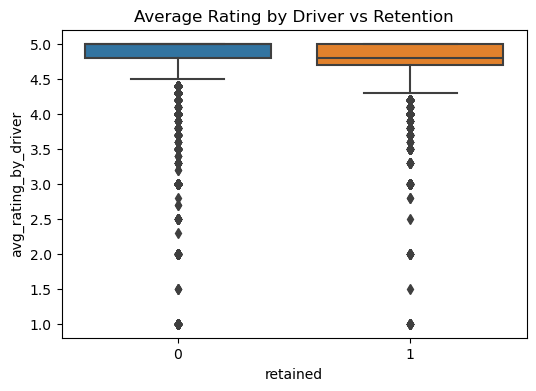

In [30]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='retained', y='avg_rating_by_driver', data=df)
plt.title("Average Rating by Driver vs Retention")
plt.show()

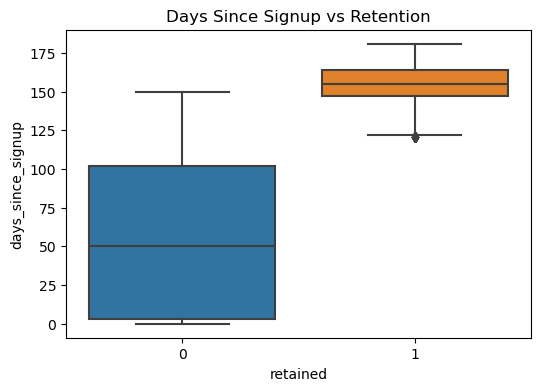

In [31]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='retained', y='days_since_signup', data=df)
plt.title("Days Since Signup vs Retention")
plt.show()

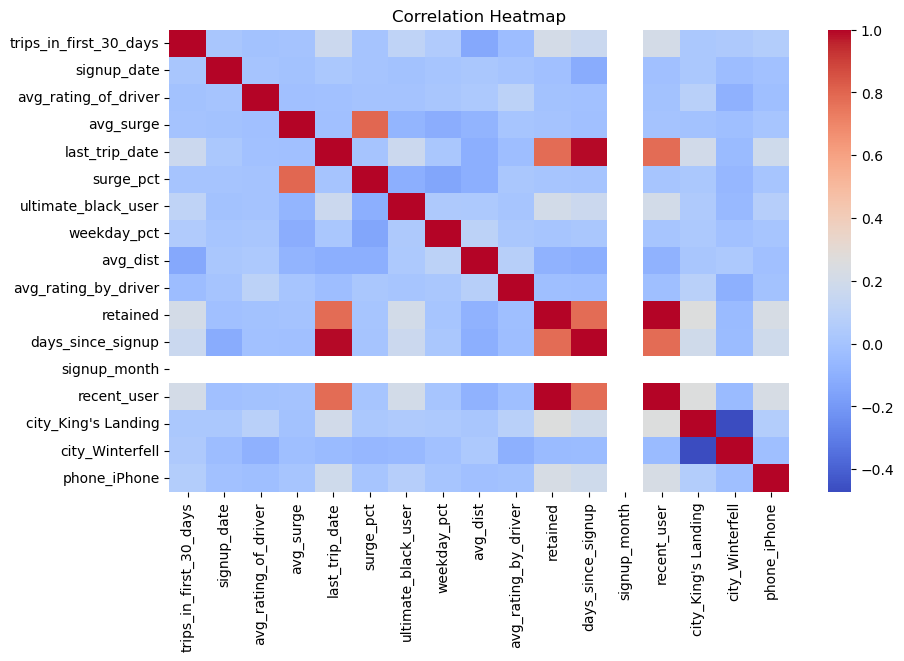

In [32]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

### **Model Training & Evaluation**

In [41]:
corrs = df.corr()['retained'].sort_values(ascending=False)
print(corrs)

retained                  1.000000
recent_user               1.000000
last_trip_date            0.780430
days_since_signup         0.778079
city_King's Landing       0.262398
phone_iPhone              0.227150
trips_in_first_30_days    0.210456
ultimate_black_user       0.206639
surge_pct                 0.011283
weekday_pct               0.009644
avg_surge                -0.004035
avg_rating_of_driver     -0.010589
signup_date              -0.020366
avg_rating_by_driver     -0.026330
city_Winterfell          -0.046400
avg_dist                 -0.092014
signup_month                   NaN
Name: retained, dtype: float64


In [45]:
leakage_features = ['recent_user', 'days_since_signup']

In [46]:
X = df.drop(columns=['retained', 'signup_date', 'last_trip_date'] + leakage_features)
y = df['retained']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [58]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

In [59]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='roc_auc')
print("Random Forest CV ROC AUC (mean):", round(cv_scores.mean(), 4))
print("Random Forest CV ROC AUC (std):", round(cv_scores.std(), 4))

Random Forest CV ROC AUC (mean): 0.8263
Random Forest CV ROC AUC (std): 0.0047


In [60]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:,1]

In [61]:
print("Test Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Test ROC AUC:", round(roc_auc_score(y_test, y_proba),4))

Test Accuracy: 0.7506

Confusion Matrix:
 [[7535 1745]
 [1966 3636]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      9280
           1       0.68      0.65      0.66      5602

    accuracy                           0.75     14882
   macro avg       0.73      0.73      0.73     14882
weighted avg       0.75      0.75      0.75     14882

Test ROC AUC: 0.8149


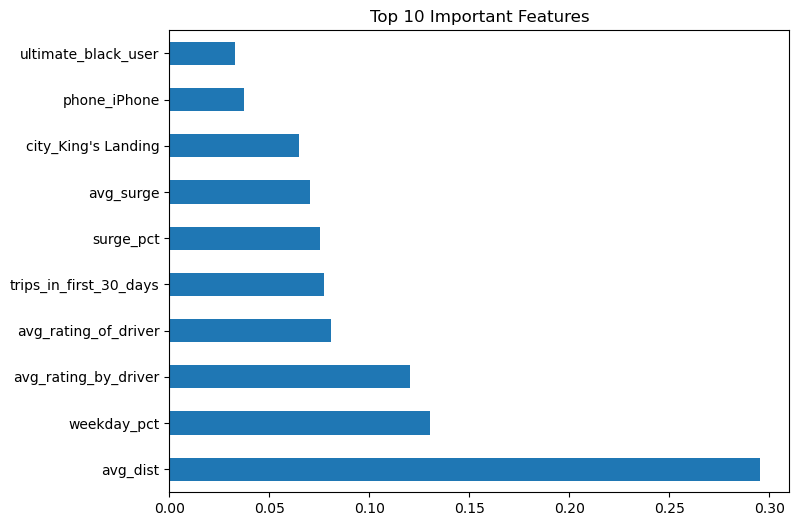

In [62]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(8,6))
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

Recommendations:
1. Encourage early engagement: more trips in the first 30 days improves retention.
2. Promote Ultimate Black experience: early premium use correlates with retention.
3. Monitor ratings: both rider and driver ratings impact retention.
4. Use cross-validation to validate model stability and prevent overfitting.